In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np
import math

import matplotlib.pyplot as plt

### Data Generation

In [2]:
np.random.seed(32)

In [3]:
### Data of g function distribution
### Cos함수와 관련된 데이터를 만드는 함수

# cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)
def Cos(samples, alpha, xmin, xmax):
    """
    Generate datas we will use for the Model
    cos(alpha_0*x_0 + alpha_1*x_1 + ... + alpha_n*x_n)

    INPUT
    samples(int) : number of datas
    coefficients(array)\vec{\aplpha}] : coefficients for the x_i
    dim(int)[\vec{x}] : dimension of x data
    xmax : max value of each x_i
    xmin : min value of each x_i

    OUTPUT
    data sets(\vec{x}, cos(\vec{\alpha} \dot \vec{x}))
    """
    points= []
    results = []
    dim = len(alpha)

    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a

    # Mading sample points
    for i in range(samples):
        
        point = []
        for j in range(dim):
            x  = np.random.uniform(xmin[j], xmax[j])
            alpha0 = np.random.uniform(0, 5) ## cos(x*a + a0)
            point.append(x)


        result = np.cos(f(alpha, point)+alpha0)
        point.append(alpha0)

        points.append(point)
        results.append(result)

    return np.array(points, requires_grad = False), np.array(results, requires_grad = False)


# ------------------------------------------------------------------ #
alphas = [1, 1]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[np.pi]*xdim
Xdata, ydata = Cos(10, alphas, xmin , xmax)
print(Xdata.shape)
print(ydata)
print(Xdata[:,0])

(10, 3)
[-0.97921815  0.54773339 -0.70649724  0.49754885  0.39457895 -0.14733951
  0.69238627 -0.98908647 -0.28281496  0.94463447]
[2.69828021 2.3143158  1.91357289 2.08209846 1.85165858 2.86170292
 1.4200579  0.50461542 0.52307556 2.1200552 ]


In [4]:
Xdata[:,:len(xmin)].shape

(10, 2)

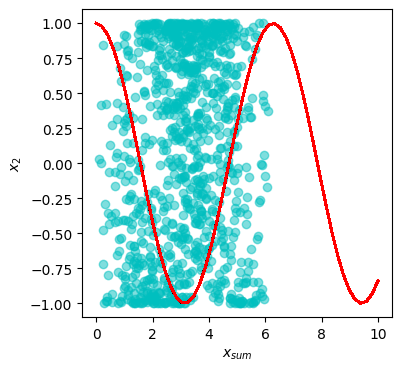

In [5]:
def plot_data(x, alpha, y, fig = None, ax = None):
    
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    def f(alpha, point):
        if len(alpha) != len(point):
            ValueError("dimension of alpha and x is not same")
    
        a = np.dot(alpha, point)
        return a
    
    for i in range(len(x)):
        x1 = f(alpha, x[i])
        x2 = y[i]
        s = np.linspace(0, 10)
        ax.scatter(x1, x2, alpha=0.5, color = 'c')
        ax.plot(s, np.cos(s), color = 'r')
        ax.set_xlabel("$x_{sum}$")
        ax.set_ylabel("$x_2$")

# ------------------------------------------------------------------ #

fig, ax = plt.subplots(figsize=(4, 4))
Xdata, ydata = Cos(1000, alphas, xmin=xmin, xmax = xmax)
plot_data(Xdata[:,:xdim], alphas, ydata, fig, ax) # for making cos(x*a + a0)

### Variational Quantum Circuit Model

[0.58783139 0.98569801 0.74492614 0.00540583 0.02688372 0.83097509
 0.97327362 0.63412706 0.16592794 0.30121803 0.94594471 0.53493135
 0.85395566 0.24424206 0.64830775 0.86388782 0.71136638 0.06703812
 0.71119893 0.16812912 0.74428623 0.34729881 0.74289994 0.66891558
 0.9029091  0.50463116 0.37026354 0.10016317 0.8898174  0.97265128]
3
------------------------------------------------------------------
0.4159269790164468
------------------------------------------------------------------


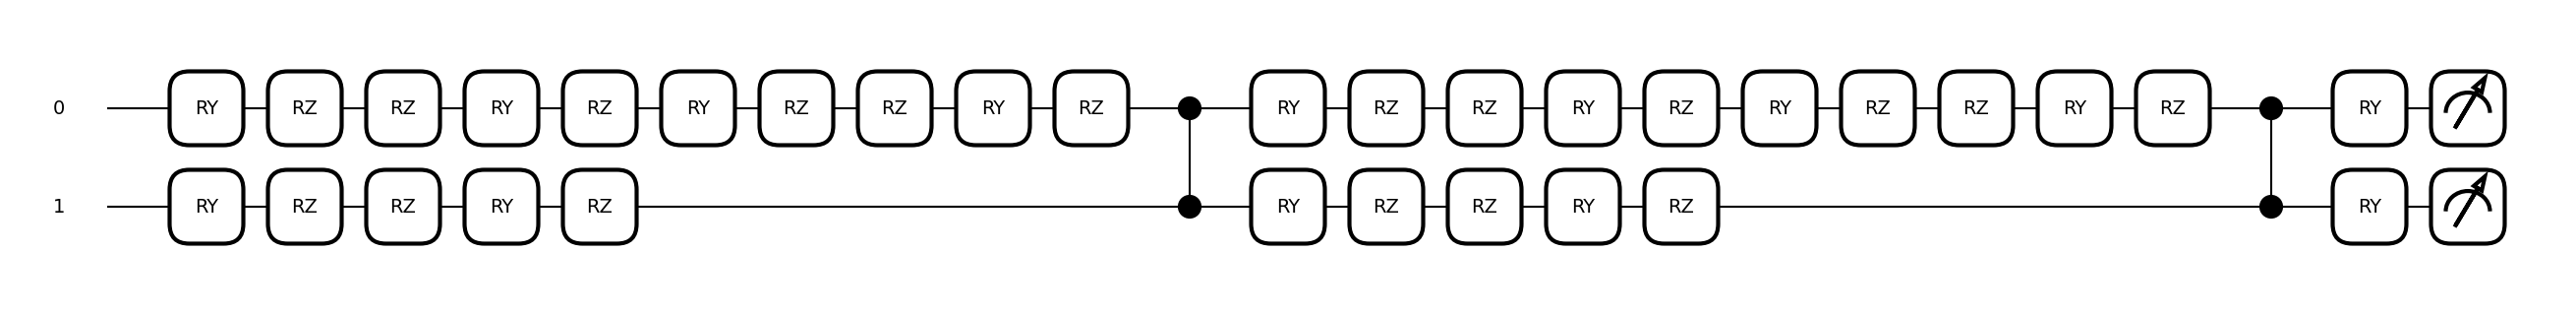

In [10]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def VQC_Model(thetas, phis, x, num_layers):
    """
    Variational Quantum Circuit model for Multi Variable Integration

    INPUT
    params : parameters for the circuit we will train them
    phis : array of parameters applied to the last RY gate
    x(Xdata[i]) : data point we have to upload
    num_layers : layers for the circuit

    OUTPUT
    Expectation value with PauliZ measure
    """
    
    dim = len(x)
    num_qubits = math.ceil(dim / 2)
    idx = 0

    params = list(thetas).copy()
    
    for _ in range(num_layers):
        for i in range(dim):
            qubit = i // 2
            qml.RY(params[idx], wires = qubit)
            qml.RZ(params[idx+1]*x[i], wires = qubit, id = f'x{i}') # Re-uploading data here
            qml.RZ(params[idx+2], wires = qubit)
            qml.RY(params[idx+3], wires = qubit)
            qml.RZ(params[idx+4], wires = qubit)
            idx += 5

        if num_qubits > 1:
            for q in range(0,num_qubits-1,1):
                qml.CZ([q, q+1])
            if num_qubits > 2:
                qml.CZ([num_qubits-1, 0])

    if num_qubits > 1:
        for i in range(num_qubits):
           qml.RY(phis[i], wires=i, id = f"phi{i}")
    
    obs = qml.PauliZ(0)
    for i in range(num_qubits-1):
         obs = obs @ qml.PauliZ(i+1)

    return qml.expval(obs)

# ------------------------------------------------------------------ #
alphas = [1, 1]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[np.pi]*xdim

Xdata, ydata = Cos(10, alphas, xmin, xmax)
x = Xdata[0]
dim = len(x)
num_layers = 2
num_qubits = math.ceil(len(x) / 2)

thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)


print(thetas)
print(len(x))
print('------------------------------------------------------------------')
print(VQC_Model(thetas, phis, x, num_layers))
print('------------------------------------------------------------------')
fig, ax = qml.draw_mpl(VQC_Model)(thetas, phis, x, num_layers)


### Cost function

In [11]:
def cost_function(thetas, phis, Xdata, num_layers, y):
    loss = 0.0

    for i in range(len(Xdata)):
        prediction = VQC_Model(thetas, phis, Xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(Xdata)

# ------------------------------------------------------------------ #

#Xdata, ydata = Cos(100, [1, 2, 1/2], 3, xmax=[np.pi, np.pi, np.pi], xmin = [0, 0, 0])
#x = Xdata[:20]
#dim = len(x)
#num_layers = 2
#num_qubits = math.ceil(len(x) / 2)

#thetas = np.random.uniform(size = dim*num_layers*5,requires_grad = True)
#phis = np.random.uniform(size = num_qubits, requires_grad =True)

#cost_function(thetas, phis, x, num_layers, ydata)


### Model Running

In [12]:
def model_running(thetas, phis, x, num_layers):
    """
    Model running with given set of data.

    INPUT


    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    
    exepctation_values = []

    for i in range(len(x)):
        expval = VQC_Model(thetas, phis, x[i], num_layers)
        exepctation_values.append(expval)
        
    return np.array(exepctation_values)

In [13]:
def accuracy(ypred, ydata):

    ratio = []
    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
        ratio.append(ypred[i] / ydata[i])

    return ratio, score/len(ydata)

In [14]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-------------

In [15]:
### Preparing datas
alphas = [1, 1]
xdim = len(alphas)
xmin = [0]*xdim
xmax=[np.pi]*xdim

train_data, train_target = Cos(250, alphas, xmin, xmax)
test_data, test_target = Cos(750, alphas, xmin, xmax)

# for making cos(x*a + a0)
x = train_data[0]
dim = len(x)

# Trainnig option settings
num_layers = 2
epochs = 100
batch_size = 50
lr = 0.03

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
thetas = np.random.uniform(size=dim*num_layers*5, requires_grad=True)
phis = np.random.uniform(size = num_qubits, requires_grad =True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(thetas, phis, train_data, num_layers)
ratio_train, score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(thetas, phis, test_data, num_layers)
ratio_test, score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(thetas, phis, test_data, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        thetas, phis, _, _, _ = opt.step(cost_function, thetas, phis, Xbatch, num_layers, ybatch)

    pred_train = model_running(thetas, phis, train_data, num_layers)
    ratio_train, score_train = accuracy(pred_train, train_target)
    loss = cost_function(thetas, phis, train_data, num_layers, train_target)

    pred_test = model_running(thetas, phis, test_data, num_layers)
    ratio_test, score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)


Epoch:  0 | Cost: 0.684166 | Train accuracy: 0.068000 | Test Accuracy: 0.088000
Epoch:  1 | Loss: 0.569478 | Train accuracy: 0.020000 | Test accuracy: 0.025333
Epoch:  2 | Loss: 0.498464 | Train accuracy: 0.016000 | Test accuracy: 0.049333
Epoch:  3 | Loss: 0.476239 | Train accuracy: 0.016000 | Test accuracy: 0.029333
Epoch:  4 | Loss: 0.444959 | Train accuracy: 0.024000 | Test accuracy: 0.017333
Epoch:  5 | Loss: 0.421908 | Train accuracy: 0.052000 | Test accuracy: 0.028000
Epoch:  6 | Loss: 0.391163 | Train accuracy: 0.040000 | Test accuracy: 0.033333
Epoch:  7 | Loss: 0.362348 | Train accuracy: 0.044000 | Test accuracy: 0.054667
Epoch:  8 | Loss: 0.336714 | Train accuracy: 0.064000 | Test accuracy: 0.072000
Epoch:  9 | Loss: 0.314189 | Train accuracy: 0.084000 | Test accuracy: 0.085333
Epoch: 10 | Loss: 0.288054 | Train accuracy: 0.084000 | Test accuracy: 0.102667
Epoch: 11 | Loss: 0.257868 | Train accuracy: 0.072000 | Test accuracy: 0.101333
Epoch: 12 | Loss: 0.225990 | Train accur

KeyboardInterrupt: 

Cost: 0.000044 | Train accuracy 0.992000 | Test Accuracy : 0.988000
Learned weights
thetas = [ 1.71725023  0.88171938  0.02810289  0.04328258  0.41802114 -0.07368152
  0.38519398  0.45635528  0.27233528  1.18702576 -1.49792113 -0.05164528
 -0.74309343 -0.10477063  0.93452762 -0.03448183  0.13833967  0.75448421
 -0.18777145  0.65159003  0.34998332  0.63594534  0.16832023  1.41788498
 -0.2046666   1.67389826  0.99645395 -0.5464233  -1.59380298  0.37173196]
phis = [0.12822044 0.15855813]


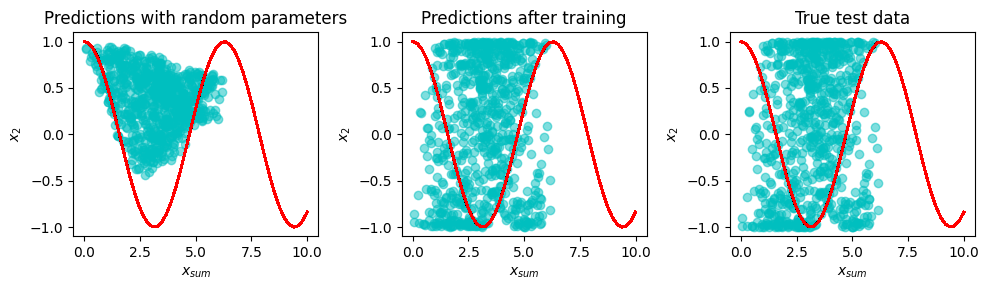

In [16]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, score_train, score_test
    )
)

print("Learned weights")
print("thetas = {}".format(thetas))
print("phis = {}".format(phis))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data[:,:xdim], alphas, initial_predictions, fig, axes[0])
plot_data(test_data[:,:xdim], alphas, pred_test, fig, axes[1])
plot_data(test_data[:,:xdim], alphas, test_target, fig, axes[2])

axes[0].set_title("Predictions with random parameters")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


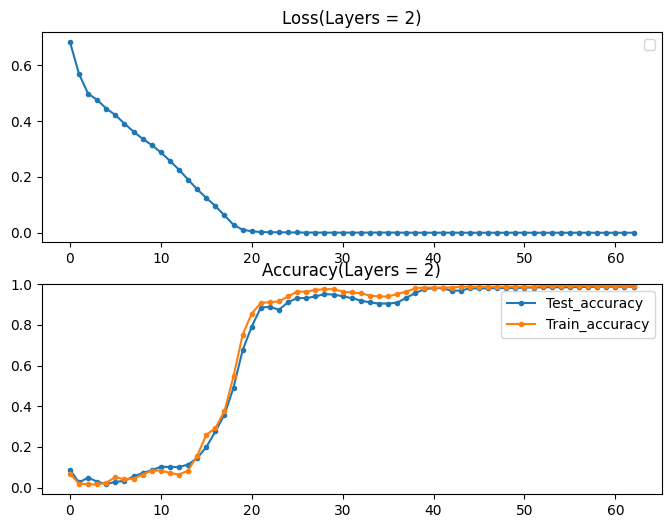

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[0].legend()
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss(Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

### Results for $g_{est}$

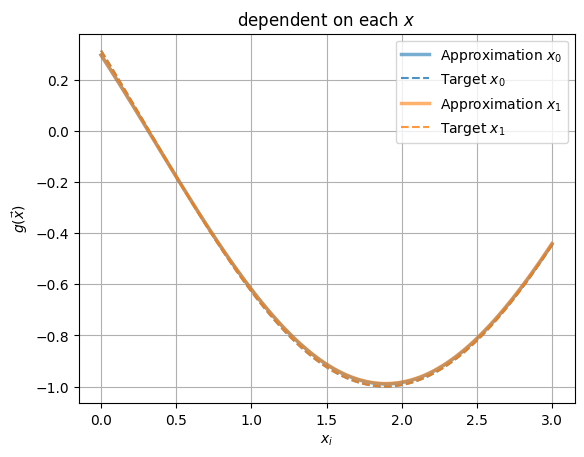

In [52]:
xlin = np.linspace(0, 3,100)
arr = np.zeros(100)
alpha0 = [1.25]*100

alphas = [1, 1]
xdim = len(alphas)

xlin_data1 = np.stack((xlin, arr, alpha0), axis=1)
xlin_data2 = np.stack((arr, xlin, alpha0), axis=1)
integral = 0
xlin_data = np.stack((xlin_data1, xlin_data2), axis=0)
for i in range(xdim):
        ypred = model_running(thetas, phis, xlin_data[i], num_layers)
        ytrue = np.cos(alphas[i]*xlin+alpha0)

        color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

        plt.plot(xlin, 
                ypred,
                label=f"Approximation $x_{i}$",
                linewidth = 2.5,
                alpha = 0.6,
                ls = "-",
                color = color)

        plt.plot(
                xlin,
                ytrue,
                label=f"Target $x_{i}$",
                linewidth=1.5,
                alpha=0.8,
                ls="--",
                color=color)
        
plt.grid(True)
plt.title(f"dependent on each $x$")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$g({\vec{x}})$")
plt.legend()
plt.show()

### Results for $I(\cdots,x_{i-1},x_{i+1},\cdots)$

#### 변수 $x_2$와 $x_3$에 대한 적분을 수행하고 그 결과를 $ x_1 $값의 함수로 표현하고 싶다면, 우리는 두 변수에 대한 이중적분을 계산

#### 함수 $ f(x_1, x_2, x_3) = \cos(x_1 + 2x_2 + 0.5x_3 + \alpha_0) $에 대해 $ \alpha_0 = 1.25 $로 고정하고, $ x_2 $와 $ x_3 $에 대해 0부터 3까지의 적분을 리만 적분으로 근사

1. **이중적분 설정**:
$ I(x_1) = \int_{0}^{3} \int_{0}^{3} \cos(x_1 + 2x_2 + 0.5x_3 + 1.25) \, dx_2 \, dx_3 $

2. **구간 나누기**:
두 변수 $ x_2 $와 $ x_3 $에 대해 구간 [0, 3]을 $ N $개의 작은 구간으로 나눕니다. 각 변수에 대한 구간의 너비는 $ \Delta x = \frac{3 - 0}{N} $로 동일

3. **함수의 값 계산**:
이중 합을 사용하여 리만 합을 계산하기 위해, 각 구간에 대한 대표값 $ x_{2i} $와 $ x_{3j} $에서 함수의 값을 계산

4. **이중 리만 합 계산**:
각 대표값에서 함수의 값을 곱한 후, 모든 $ x_2 $와 $ x_3 $의 구간에 대해 이를 더하여 이중 리만 합을 계산

$ I_{\text{Riemann}}(x_1) = \sum_{i=1}^{N} \sum_{j=1}^{N} \cos(x_1 + 2x_{2i} + 0.5x_{3j} + 1.25) \Delta x^2 $

5. **적분값 계산**:
리만 합을 계산한 후, $ N $을 충분히 크게 취하여 근사적분값 $ I_{\text{Riemann}}(x_1) $이 실제 이중적분 값에 근사됨

6. **결과 해석**:
$ x_1 $에 대해 $ I_{\text{Riemann}}(x_1) $를 계산하면, 이는 $ x_1 $의 함수로서의 이중적분 결과를 얻을 수 있음

In [41]:
xlin = np.linspace(0,1,100)

In [45]:
# Define the integrand function
def integrand(thetas, phis, x, num_layers):
    return model_running(thetas, phis, x, num_layers)
# Set the value for alpha0
alpha0 = 1.25

# Set the bounds of the integration for x2 and x3
lower_bound = 0
upper_bound = 1

# Choose the number of points for the Riemann sum (more points -> better approximation)
N = 101  # This is an example; in practice, you might need a larger number for a good approximation
delta_x = (upper_bound - lower_bound) / (N-1)

# Initialize the sum
I_riemann = 0

# Compute the Riemann sum
integral_results = []
for x1 in xlin:
    I_riemann = 0
    for i in range(N):
        x2 = lower_bound + i * delta_x
        int_data = np.array([[x1,x2,alpha0]], requires_grad=False)
        I_riemann += integrand(thetas, phis, int_data, num_layers) * delta_x**(xdim-1)
    integral_results.append(I_riemann)


In [49]:
# To-do: numerical integration results, maybe we can use integrand with true g(x,a)
ytrue = -0.943495985118008*np.sin(xlin) - 0.170911422467665*np.cos(xlin)

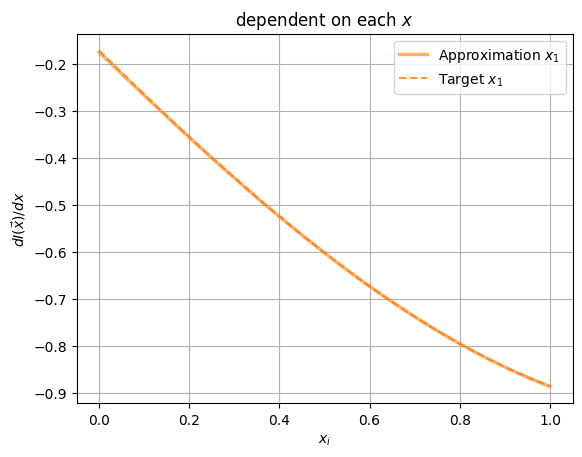

In [47]:
i = 1 # x_1
color = plt.rcParams["axes.prop_cycle"].by_key()["color"][i]

plt.plot(xlin, 
        integral_results,
        label=f"Approximation $x_{i}$",
        linewidth = 2.5,
        alpha = 0.6,
        ls = "-",
        color = color)

plt.plot(
        xlin,
        ytrue,
        label=f"Target $x_{i}$",
        linewidth=1.5,
        alpha=0.8,
        ls="--",
        color=color)
        
plt.grid(True)
plt.title(f"dependent on each $x$")
plt.xlabel(f"$x_i$")
plt.ylabel(r"$dI({\vec{x}})/dx$")
plt.legend()
plt.show()